# Chapter 8.8 Computing

In [86]:
sessionInfo()

R version 3.4.4 (2018-03-15)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.14.4

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.4/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.4/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] party_1.3-1         strucchange_1.5-1   sandwich_2.5-0     
 [4] zoo_1.8-3           modeltools_0.2-22   mvtnorm_1.0-8      
 [7] xtable_1.8-3        caret_6.0-81        ggplot2_3.1.0      
[10] lattice_0.20-35     randomForest_4.6-14 mlbench_2.1-1      

loaded via a namespace (and not attached):
 [1] jsonlite_1.5       splines_3.4.4      foreach_1.4.4      prodlim_2018.04.18
 [5] assertthat_0.2.0   coin_1.2-2         ipred_0.9-8        pillar_1.3.0      
 [9] glue_1.3.

## 8.1 Recreate the simulated data from Exercise 7.2:

In [87]:
library(mlbench)
set.seed(200)
simulated <- mlbench.friedman1(200, sd = 1)
simulated <- cbind(simulated$x, simulated$y)
simulated <- as.data.frame(simulated)
colnames(simulated)[ncol(simulated)] <- "y"

### (a) Fit a random forest model to all of the predictors, then estimate the variable importance scores:

In [88]:
library(randomForest)
library(caret)
model1 <- randomForest(y ~ ., data = simulated,
                       importance = TRUE,
                       ntree = 1000)
rfImp1 <- varImp(model1, scale = FALSE)

### Did the random forest model signiﬁcantly use the uninformative predictors (V6 – V10)?

In [89]:
rfImp1

,Overall
V1,8.83890885
V2,6.49023056
V3,0.67583163
V4,7.58822553
V5,2.27426009
V6,0.17436781
V7,0.15136583
V8,-0.03078937
V9,-0.02989832
V10,-0.08529218


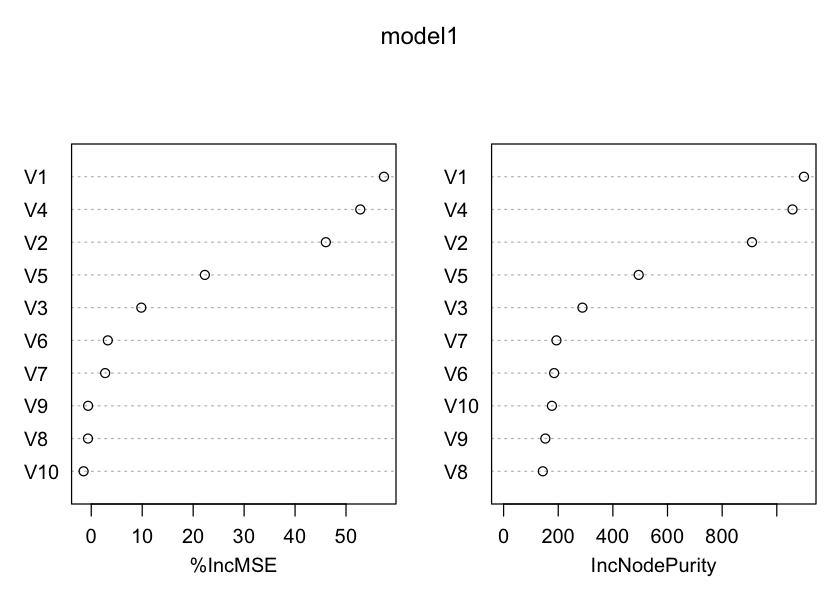

In [64]:
options(repr.plot.width=7, repr.plot.height=5)
varImpPlot(model1)

As we can see, the uninformative variables (V6 - V10) were not used as significant as the other variables

### (b) Now add an additional predictor that is highly correlated with one of the informative predictors. For example:

In [90]:
simulated$duplicate1 <- simulated$V1 + rnorm(200) * .1
cor(simulated$duplicate1, simulated$V1)

[1] 0.9396216

### Fit another random forest model to these data. Did the importance score for V1 change? What happens when you add another predictor that is also highly correlated with V1?

In [66]:
model2 <- randomForest(y ~ ., data = simulated,
                       importance = TRUE,
                       ntree = 1000)

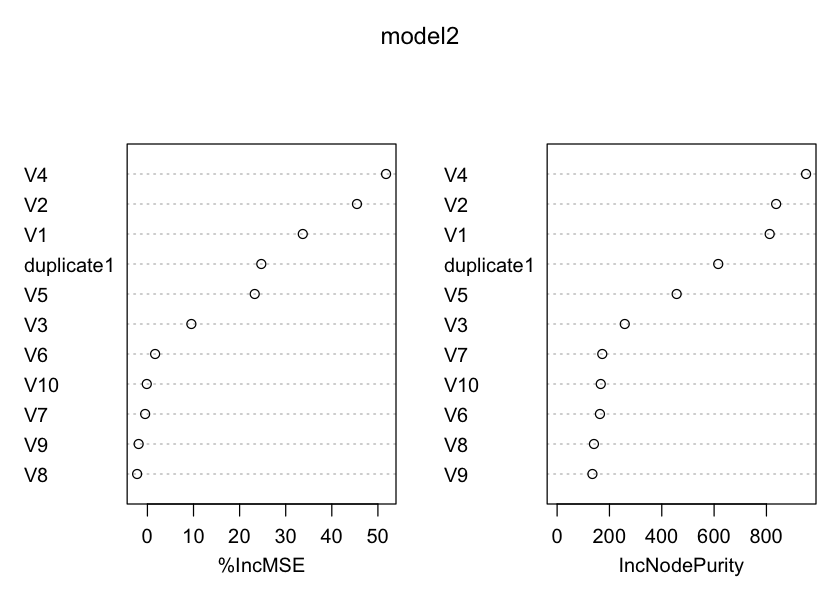

In [92]:
varImpPlot(model2)

In [93]:
rfImp2 <- varImp(model2, scale = FALSE)
rfImp2

,Overall
V1,6.29780744
V2,6.08038134
V3,0.58410718
V4,6.93924427
V5,2.03104094
V6,0.07947642
V7,-0.02566414
V8,-0.11007435
V9,-0.08839463
V10,-0.00715093


In [94]:
cbind(rbind(rfImp1, "duplicate1" = 0), rfImp2)

,Overall,Overall
V1,8.83890885,6.29780744
V2,6.49023056,6.08038134
V3,0.67583163,0.58410718
V4,7.58822553,6.93924427
V5,2.27426009,2.03104094
V6,0.17436781,0.07947642
V7,0.15136583,-0.02566414
V8,-0.03078937,-0.11007435
V9,-0.02989832,-0.08839463
V10,-0.08529218,-0.00715093


This decreases importance of the predictor V1.

### (c) Use the cforest function in the party package to ﬁt a random forest model using conditional inference trees. The party package function varimp can calculate predictor importance. The conditional argument of that function toggles between the traditional importance measure and the modiﬁed version described in Strobl et al. (2007). Do these importances show the same pattern as the traditional random forest model?

In [111]:
library(party)
set.seed(47)
simulated_ori <- simulated[, !colnames(simulated) %in% c('duplicate1')]
model3 <- cforest(y ~ ., data=simulated_ori,
                 control=cforest_unbiased(ntree = 1000))
model4 <- cforest(y ~ ., data=simulated_ori,
                 control=cforest_classical(ntree = 1000))

In [119]:
d <- data.frame(varImp(model1, scale = FALSE), varImp(model3), varImp(model4))
colnames(d) <- c("random forest", "cforest_unbiased", "cforest_classical")

In [80]:
varImp(model3)

,Overall
V1,6.805980717
V2,6.169863723
V3,-0.006302359
V4,7.695075610
V5,1.820495742
V6,-0.024228562
V7,0.023238921
V8,-0.054485084
V9,-0.008140617
V10,-0.029754013


In [120]:
d

,random forest,cforest_unbiased,cforest_classical
V1,8.83890885,8.911598714,9.01359459
V2,6.49023056,6.538804719,6.75334205
V3,0.67583163,0.024218012,0.06950049
V4,7.58822553,8.503106066,8.66712634
V5,2.27426009,2.013761765,2.19851154
V6,0.17436781,-0.009487365,-0.02531449
V7,0.15136583,0.015529441,0.06829946
V8,-0.03078937,-0.028072404,-0.01584600
V9,-0.02989832,-0.019521724,-0.06001097
V10,-0.08529218,-0.037879377,0.04679970


Yes it does show similar pattern as the random forest in a way that it shows same order for the significant variables. Digits are different

### (d) Repeat this process with diﬀerent tree models, such as boosted trees and Cubist. Does the same pattern occur?


In [137]:
library(gbm)

In [138]:
########## Boosted ##########
ptm <- proc.time()
model5 <- gbm(y ~ ., data=simulated_ori,
              distribution="gaussian",
              n.trees=1000)
model6 <- gbm(y ~ .,, data=simulated,
              distribution="gaussian",
              n.trees=1000)
print(proc.time() - ptm)

   user  system elapsed 
  0.119   0.002   0.131 


,var,rel.inf
V1,V1,40.599092
V4,V4,30.396610
V2,V2,27.839263
V5,V5,1.165034
V3,V3,0.000000
V6,V6,0.000000
V7,V7,0.000000
V8,V8,0.000000
V9,V9,0.000000
V10,V10,0.000000


,var,rel.inf
V1,V1,35.320139
V4,V4,29.779952
V2,V2,27.215141
duplicate1,duplicate1,6.657092
V5,V5,1.027676
V3,V3,0.000000
V6,V6,0.000000
V7,V7,0.000000
V8,V8,0.000000
V9,V9,0.000000


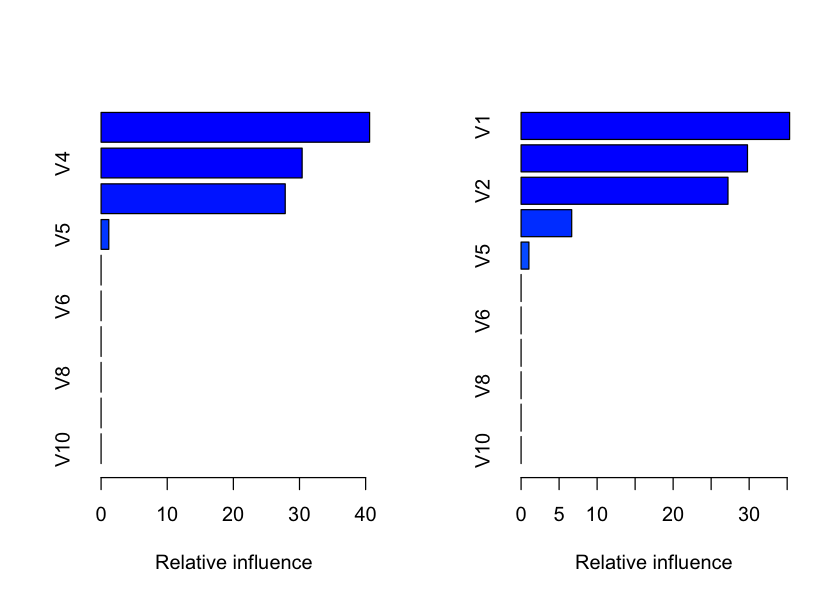

In [160]:
par(mfrow = c(1,2))
summary(model5)
summary(model6)
par(mfrow = c(1,1))

---

In [140]:
library(Cubist)

In [153]:
########## Cubist ##########
ptm <- proc.time()
set.seed(46)
model7 <- cubist(x=simulated_ori[, !colnames(simulated_ori) %in% c("y")],
                 y=simulated_ori$y)
model8 <- cubist(x=simulated[, !colnames(simulated) %in% c("y")],
                 y=simulated$y)

In [162]:
summary(model7)
summary(model8)


Call:
cubist.default(x = simulated_ori[, !colnames(simulated_ori) %in% c("y")], y
 = simulated_ori$y)


Cubist [Release 2.07 GPL Edition]  Fri Feb 22 08:49:49 2019
---------------------------------

    Target attribute `outcome'

Read 200 cases (11 attributes) from undefined.data

Model:

  Rule 1: [200 cases, mean 14.416183, range 3.55596 to 28.38167, est err 1.944664]

	outcome = 0.183529 + 8.9 V4 + 7.9 V1 + 7.1 V2 + 5.3 V5


Evaluation on training data (200 cases):

    Average  |error|           2.224012
    Relative |error|               0.55
    Correlation coefficient        0.84


	Attribute usage:
	  Conds  Model

	         100%    V1
	         100%    V2
	         100%    V4
	         100%    V5


Time: 0.0 secs



Call:
cubist.default(x = simulated[, !colnames(simulated) %in% c("y")], y
 = simulated$y)


Cubist [Release 2.07 GPL Edition]  Fri Feb 22 08:49:49 2019
---------------------------------

    Target attribute `outcome'

Read 200 cases (12 attributes) from undefined.data

Model:

  Rule 1: [200 cases, mean 14.416183, range 3.55596 to 28.38167, est err 1.944664]

	outcome = 0.183529 + 8.9 V4 + 7.9 V1 + 7.1 V2 + 5.3 V5


Evaluation on training data (200 cases):

    Average  |error|           2.199542
    Relative |error|               0.54
    Correlation coefficient        0.84


	Attribute usage:
	  Conds  Model

	         100%    V1
	         100%    V2
	         100%    V4
	         100%    V5


Time: 0.0 secs


Cubist shows that V1, V2, V4, V5 are most significant predictors. Except that there is no V3 in the list. That is actually along with results from other model. Random forest and boosted model shows that V3 is not as significant as other predictors.

## 8.2. Use a simulation to show tree bias with diﬀerent granularities.

I will make a simulation using a different predictors, one with more granularity than the other but not relevant to the response, one with less granularity than the other but relevant to the response

In [217]:
set.seed(46)
X1 <- rep(1:2, each=200)
Y <- X1 + rnorm(400, mean=0, sd=4)
set.seed(26)
X2 <- rnorm(400, mean=0, sd=2)
dd <- data.frame(Y=Y, X1=X1, X2=X2)

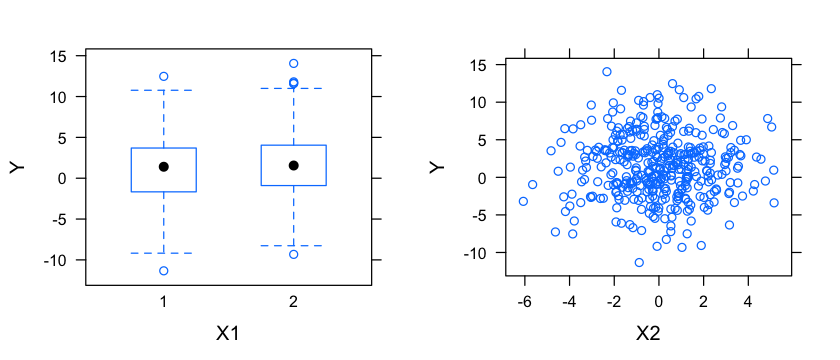

In [218]:
options(repr.plot.width=7, repr.plot.height=3)
bw <- bwplot(Y~X1,
             data=dd,
             horizontal=FALSE)
xy <- xyplot(Y~X2,
             data=dd)
print(bw, split=c(1,1,2,1), more=TRUE)
print(xy, split=c(2,1,2,1))
## We can see that from the graphs below, X2 is not relevant while X1 is

In [219]:
library(rpart)
tune1 <- rpart(Y~X1+X2, data=dd,
               control=rpart.control(maxdepth=1))

In [220]:
summary(tune1)

Call:
rpart(formula = Y ~ X1 + X2, data = dd, control = rpart.control(maxdepth = 1))
  n= 400 

          CP nsplit rel error   xerror       xstd
1 0.01357063      0 1.0000000 1.006359 0.07164166
2 0.01000000      1 0.9864294 1.018128 0.07245251

Variable importance
 X2 
100 

Node number 1: 400 observations,    complexity param=0.01357063
  mean=1.507199, MSE=17.87563 
  left son=2 (13 obs) right son=3 (387 obs)
  Primary splits:
      X2 < -3.84985 to the left,  improve=0.013570630, (0 missing)
      X1 < 1.5      to the left,  improve=0.002367073, (0 missing)

Node number 2: 13 observations
  mean=-1.180091, MSE=17.55758 

Node number 3: 387 observations
  mean=1.59747, MSE=17.63559 



In [229]:
selected <- data.frame(Pred=as.character())
for (i in 1:3) {
    for (j in 1:100) {
        set.seed(10 + j)
        X1 <- rep(1:2, each=100*i)
        Y <- X1 + rnorm(200*i, mean=0, sd=4)
        set.seed(33 + 3*j)
        X2 <- rnorm(200*i, mean=0, sd=2)
        dd <- data.frame(Y=Y, X1=X1, X2=X2)
        current_rpart <- rpart(Y~X1+X2, data=dd,
                               control=rpart.control(maxdepth=1))
        currentPred <- data.frame(Pred=rownames(current_rpart$splits)[1])
        selected <- rbind(selected, currentPred)
        assign(paste("selected_", i, sep=""), selected)
    }
}


In [230]:
table(selected_1)
table(selected_2)
table(selected_3)

selected_1
X1 X2 
40 56 

selected_2
X1 X2 
98 88 

selected_3
 X1  X2 
170  99 

We can see that when there are not much variable, there is a selection bias toward granularity. But as the number of samples increase, since it's becoming more granular, the tree is choosing X1 over X2

## 8.3. In stochastic gradient boosting the bagging fraction and learning rate will govern the construction of the trees as they are guided by the gradient. Although the optimal values of these parameters should be obtained through the tuning process, it is helpful to understand how the magnitudes of these parameters aﬀect magnitudes of variable importance. Figure 8.24 provides the variable importance plots for boosting using two extreme values for the bagging fraction (0.1 and 0.9) and the learning rate (0.1 and 0.9) for the solubility data. The left-hand plot has both parameters set to 0.1, and the right-hand plot has both set to 0.9:


<img src="img/img1.png" style="height:400px">

## (a) Why does the model on the right focus its importance on just the ﬁrst few of predictors, whereas the model on the left spreads importance across more predictors?
This is due to the nature of boosting. Trees from boosting are dependent on each other and hence will have correlated structures. On the left graph of the figure 8.24, both bagging fraction and shrinkage are small. This leads to high correlation between trees while the model from the right graph will have low correlation between trees in the model due to the low number of the parameters. Variable importance is calculated from improvement RMSE. When trees have higher corelation in the model, the RMSE will not change as much as when there is low correlation.

## (b) Which model do you think would be more predictive of other samples?
It will be the left one on the figure above. Since the both bagging fraction and shrinkage increase, there will be more correlation between trees as well as the higher chance of overfitting. So the model of the left graph above will be more predictive of other samples.

## (c) How would increasing interaction depth aﬀect the slope of predictor importance for either model in Fig. 8.24?
There will be more interaction between trees which leads to higher correlation, hence less steeper, more flat variable importnace graph.

## 8.4. Use a single predictor in the solubility data, such as the molecular weight or the number of carbon atoms and ﬁt several models
## And plot the predictor data versus the solubility results for the test set. Overlay the model predictions for the test set. How do the model diﬀer? Does changing the tuning parameter(s) signiﬁcantly aﬀect the model ﬁt?
## (a) A simple regression tree

In [346]:
rm(list=ls())
library(AppliedPredictiveModeling)
data(solubility) # solTestX, solTestXtrans, solTestY, solTrainX, solTrainXtrans, solTrainY
library(caret)
library(rpart)

In [347]:
MWTr <- data.frame(MolWeight=solTrainXtrans$MolWeight,
                   Y=solTrainY)
#MWTr <- subset(solTrainXtrans, select='MolWeight')

#MWTe <- data.frame(MolWeight=solTestXtrans$MolWeight)
MWTe <- subset(solTestXtrans, select='MolWeight')

In [388]:
rmse <- function(pred, obs) {
    sqrt(mean((pred - obs)^2))
}

In [394]:
rpartResults <- data.frame(Tune=character(),
                           Param=character(),
                           X=character(),
                           Y=character())
RMSE <- data.frame(RMSE=character(),
                   Tune=character())
for (i in 1:3) {
    set.seed(46)
    current_cp <- 0.0002*10^i
    current_rpModel <- rpart(solTrainY~MolWeight, data=MWTr,
                             control=rpart.control(cp=current_cp))
    current_rpmod <- data.frame(Tune=paste("cp = ", current_cp),
                                Param="cp",
                                X=MWTe$MolWeight,
                                Y=predict(current_rpModel, MWTe))
    cp_rmse <- data.frame(RMSE=rmse(MWTe$MolWeight, predict(current_rpModel, MWTe)),
                          Tune=paste("cp = ", current_cp))
    rpartResults <- rbind(rpartResults, current_rpmod)
    
    current_depth <- i
    set.seed(46)
    current_dpModel <- rpart(solTrainY~MolWeight, data=MWTr,
                             control=rpart.control(maxdepth=current_depth))
    current_dpmod <- data.frame(Tune=paste("maxDepth = ", current_depth),
                                Param="maxDepth",
                                X=MWTe$MolWeight,
                                Y=predict(current_dpModel, MWTe))
    dp_rmse <- data.frame(RMSE=rmse(MWTe$MolWeight, predict(current_dpModel, MWTe)),
                          Tune=paste("maxDepth = ", current_depth))
    rpartResults <- rbind(rpartResults, current_dpmod)
    RMSE <- rbind(RMSE, cp_rmse)
    RMSE <- rbind(RMSE, dp_rmse)
}

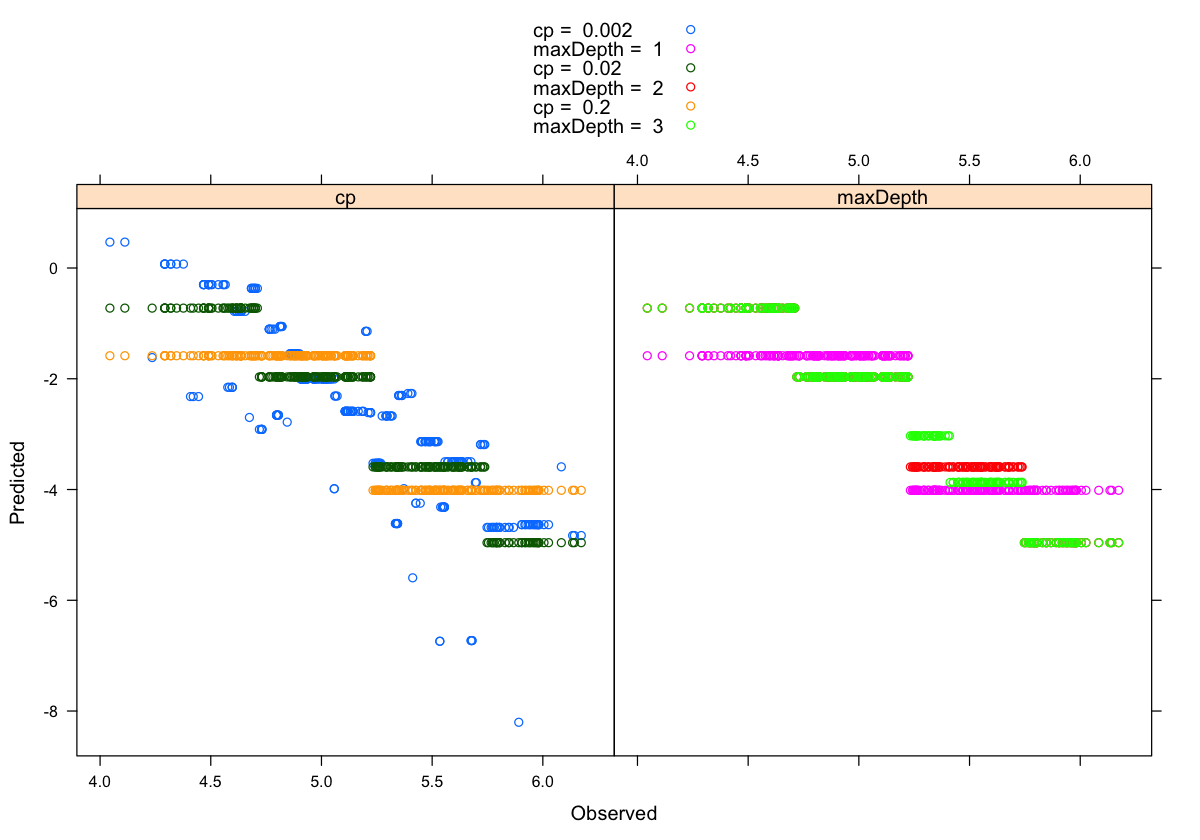

In [395]:
xyplot(Y ~ X | Param, group=Tune, rpartResults, auto.key=TRUE,
       xlab="Observed", ylab="Predicted")

As the number of complexity parameter increases, the prediction gets more discretized. Max depth graph shows the opposite trend. As the number for the max depth decreases, it gets more discretized.

In [397]:
RMSE[order(RMSE$RMSE),]

,RMSE,Tune
6,8.005417,maxDepth = 3
3,8.007420,cp = 0.02
4,8.007420,maxDepth = 2
2,8.017696,maxDepth = 1
5,8.017696,cp = 0.2
1,8.065632,cp = 0.002
